In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import statistics as st
import os
import pickle
import glob
from scipy import stats
%matplotlib inline
import random
import seaborn as sn
from IPython.display import display, HTML
from scipy.stats import norm

display(HTML("<style>.container { width:90% !important; }</style>"))

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
gain = lambda Wb,R,NPE,e:Wb/(NPE*e*R)
NumofPE=lambda Wb,R,g,e:Wb/(R*g*e)

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def getValuesWithSource(files,weight):
    values={} 

    for i in files:
        count=0
        sources={}
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                if(splitline[0] in values.keys()):
                    if(splitline[1] in values[splitline[0]].keys()):
                        values[splitline[0]][splitline[1]]=np.append(values[splitline[0]][splitline[1]],round(int(splitline[2])/weight))
                    else:
                        sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                        values[splitline[0]][splitline[1]]=sources[splitline[1]]
                else:
                    sources={}
                    sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                    values[splitline[0]]=sources
        f.close()
        
    return values
### Photons

## point Source
Point_SolidAngle=lambda r,R:(r**2/(4*R**2))

## Disk Source
### Where A is Rs/d ,and B is Rd/d
Disk_SolidAngle=lambda A,B:(B**2/4)*(1-3/4*(A**2+B**2)+15/8*(1/3*(A**4+B**4)+(A*B)**2)-35/16*(1/4*(A**6+B**6)+3/2*(A*B)**2*(A**2+B**2)))

def getAll(Path):
    Files = glob.glob(Path,recursive=True)
    Values=getValuesWithSource(Files,1)
    return Values
    
def SmearIT(mean,percent):
    return np.random.normal(mean,mean*percent)

def CombineIT(data):
    entrie=-1
    for key in data:
        if(len(data[key])>entrie):
            entrie=len(data[key])
    
    valuearr=np.zeros(entrie)
  
    print(f"Number of Values is {entrie}")
    for key in data:
        count=0 
        for val in data[key]:
            valuearr[count]=valuearr[count]+val
            count=count+1
    return valuearr

def ObtainValues(values):
    ### Applying Constants
        
    Results={}
    E1000ms=getAll(values["Path"])
    Alphas=E1000ms['All_e']["Po210"]
    Betas=E1000ms['All_e']["Bi210"]
    ## Solid Angle Calculations
    SolidAngle_AnodeWindowAlphas=Alphas*Point_SolidAngle(values["AnodeWindowRadius"],values["AnodePMTDistance"])*values["ELGain"]*values["AnodeQE"]*values["AnodeScale"]
    SolidAngle_CathodeWindowAlphas=Alphas*Point_SolidAngle(values["CathodeWindowRadius"],values["CathodePMTDistance"])*values["ELGain"]*values["CathodeQE"]*values["CathodeScale"]
    Results["SolidAngle_CathodeWindowBetas"]=Betas*Point_SolidAngle(values["CathodeWindowRadius"],values["CathodePMTDistance"])*values["ELGain"]*values["CathodeQE"]*values["CathodeScale"]
    Results["SolidAngle_AnodeWindowBetas"]=Betas*Point_SolidAngle(values["AnodeWindowRadius"],values["AnodePMTDistance"])*values["ELGain"]*values["AnodeQE"]*values["AnodeScale"]
    #### Adding Smearing 
   
    Results["CathodeAlphaPEs_SolidAngle"]=SmearIT(SolidAngle_CathodeWindowAlphas,values["Smearing"])
    Results["AnodeAlphaPEs_SolidAngle"]=SmearIT(SolidAngle_AnodeWindowAlphas,values["Smearing"])

    
    Cathode_Alphas=E1000ms["Cathode_PHOTOCATHODE"]["Po210"]*values["CathodeQE"]
    Anode_Alphas=E1000ms["Anode_PHOTOCATHODE"]["Po210"]*values["AnodeQE"]
    
    Results["CathodeBetaPEs_G4"]=E1000ms["Cathode_PHOTOCATHODE"]["Bi210"]*values["CathodeQE"]
    Results["AnodeBetaPEs_G4"]=E1000ms["Anode_PHOTOCATHODE"]["Bi210"]*values["AnodeQE"]
    ## G4
    if(not values["Updated"]):
        Cathode_Alphas=Cathode_Alphas*values["CathodeScale"]
        Anode_Alphas=Anode_Alphas*values["AnodeScale"]
        Results["CathodeBetaPEs_G4"]=Results["CathodeBetaPEs_G4"]*values["CathodeScale"]
        Results["AnodeBetaPEs_G4"]=Results["AnodeBetaPEs_G4"]*values["AnodeScale"]
        
            ##### Adding Smearing 
    Results["CathodeAlphaPEs_G4"]=SmearIT(Cathode_Alphas,values["Smearing"])
    Results["AnodeAlphaPEs_G4"]=SmearIT(Anode_Alphas,values["Smearing"])
    return Results
    
 

In [3]:
### Gains ###
IlkersGains=[3.9e6,2.6e6]
NicksGains=[3.4e6,2.2e6]

In [4]:
## Obtain the Data
Area=PickleITRead("Area.p")

#Area=PickleITRead("AreaWithMinPulse.p")
## Obtain Sim Data
#SimData=PickleITRead("Sim.p")


In [5]:
#values={"Needle":S2_NeedleOnly,
#        "NeedleInfo":S2_info_NeedleOnly,
#        "NeedleColim":S2_NeedleCollim,
#        "NeedleColimInfo":S2_info_NeedleCollim}
#PickleITDump(values,"Sim.p")

In [6]:

## Gain Calculations

### PMT Gains Ilker
Day1_PMT1_GainIL=NumofPE(Area["Day1_Ch1Area_PMT1"],50,IlkersGains[0],1.62e-19)
Day1_PMT3_GainIL=NumofPE(Area["Day1_Ch2Area_PMT3"],50,IlkersGains[1],1.62e-19)
Day2_PMT1_GainIL=NumofPE(Area["Day2_Ch1Area_PMT1"],50,IlkersGains[0],1.62e-19)
Day2_PMT3_GainIL=NumofPE(Area["Day2_Ch2Area_PMT3"],50,IlkersGains[1],1.62e-19)

### PMT Gains Nick
#Day1_PMT1_GainNk=NumofPE(Area["Day1_Ch1Area_PMT1"],50,NicksGains[0],1.62e-19)
#Day1_PMT3_GainNk=NumofPE(Area["Day1_Ch2Area_PMT3"],50,NicksGains[1],1.62e-19)
#Day2_PMT1_GainNk=NumofPE(Area["Day2_Ch1Area_PMT1"],50,NicksGains[0],1.62e-19)
#Day2_PMT3_GainNk=NumofPE(Area["Day2_Ch2Area_PMT3"],50,NicksGains[1],1.62e-19)


In [7]:
### Laptop
#path="/home/ilker/Desktop/SimResults/"
### From_External Drive
#E1000ms=getAll(path+"Mar8_2023/OriginalOldGeo/counts/Extra_*.txt")
#E1000ms=getAll(path+"Dec_16_2022/S2500/counts/Extra_*.txt")
#Electrons_1000ms=getAll(path+"Dec_21_2022/counts/Extra_*.txt")


In [8]:
###
Constants={
    "Disc":"Old_geometry_No_S1",
    "Path":"/media/ilker/Ilker/SimResults/Mar10_2023/OldGeo/counts/Extra_*.txt",
    "AnodeQE":0.10,
    "CathodeQE":0.10,
    "Smearing":(7.17/(2.355*100)), 
    "ELGain":647,
    "AnodeScale":0.91,
    "CathodeScale":0.85,
    "CathodeWindowRadius":(16.58/10)/2,
    "AnodeWindowRadius":(16.22/10)/2,
    "AnodePMTDistance" :14,
    "CathodePMTDistance" :36,
    "Updated":False
}
March_10_OldGeo=ObtainValues(Constants)

Constants={
    "Disc":"Updated_Geometry_NoS1",
    "Path":"/media/ilker/Ilker/SimResults/Mar10_2023/Updated/counts/Extra_*.txt",
    "AnodeQE":0.10,
    "CathodeQE":0.10,
    "Smearing":(7.17/(2.355*100)), 
    "ELGain":647,
    "AnodeScale":0.91,
    "CathodeScale":0.85,
    "CathodeWindowRadius":(16.58/10)/2,
    "AnodeWindowRadius":(16.22/10)/2,
    "AnodePMTDistance" :14,
    "CathodePMTDistance" :36,
    "Updated":True
}
March_10_Updated=ObtainValues(Constants)


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


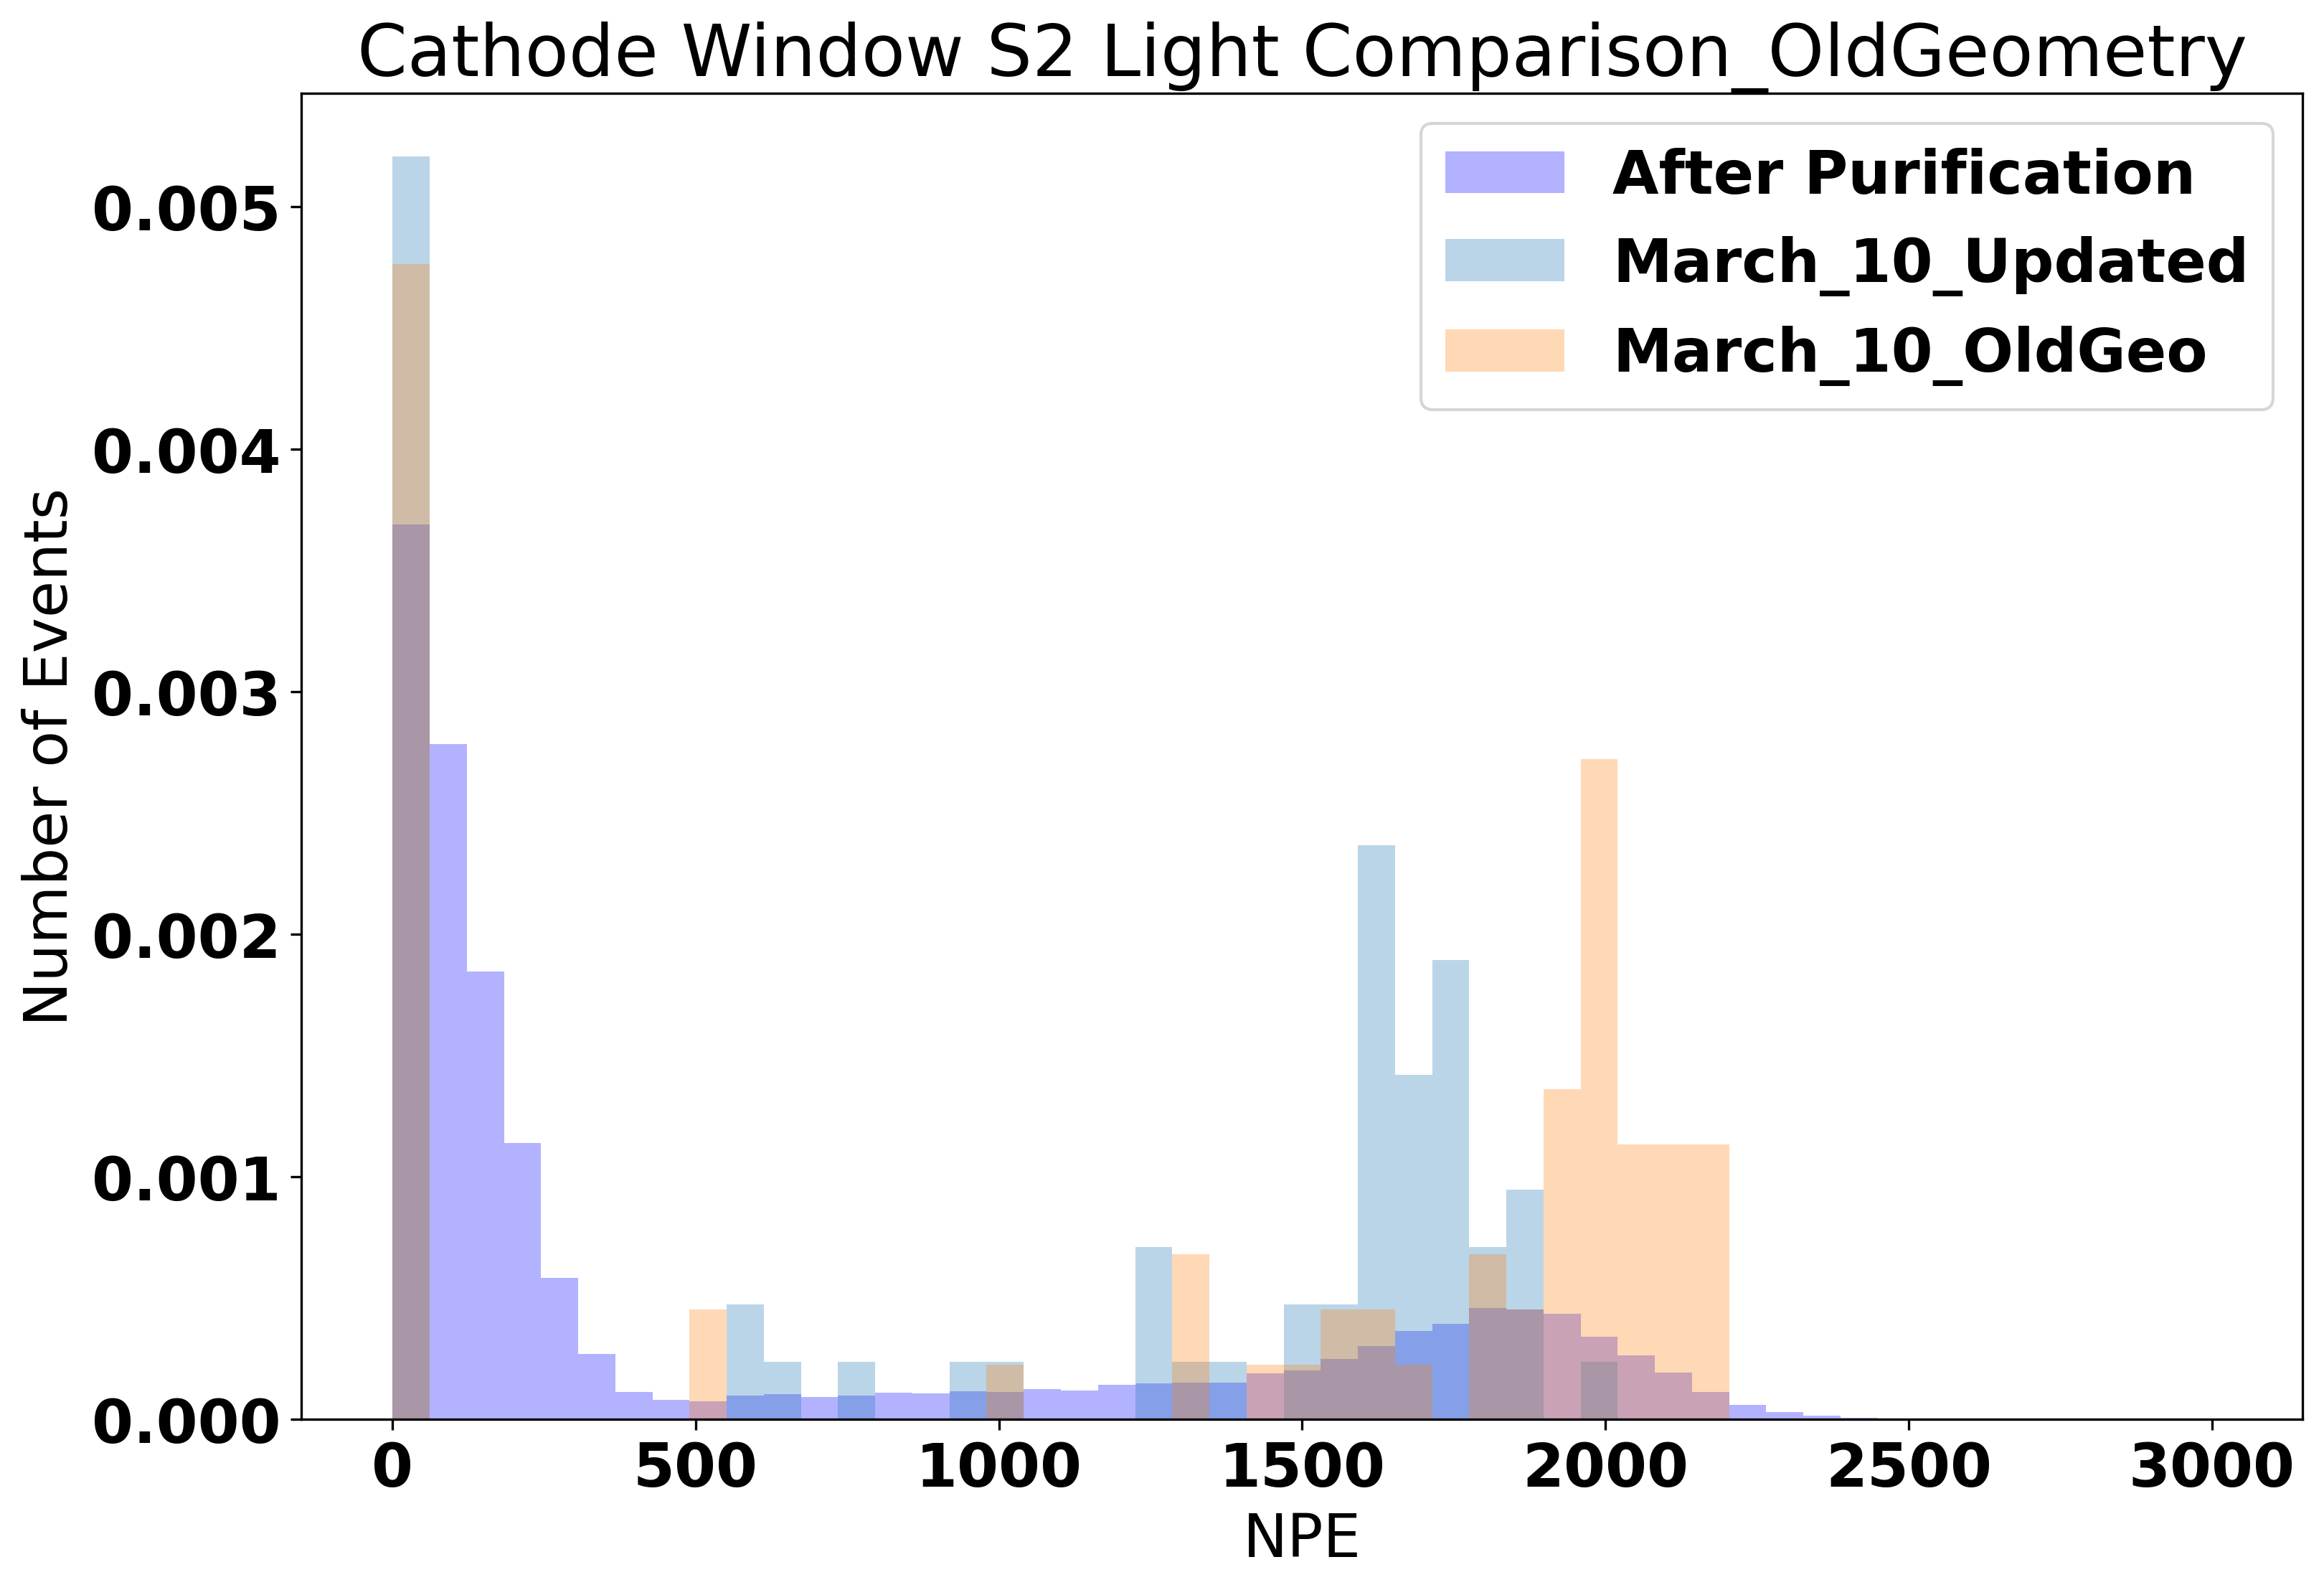

In [9]:

binss=np.linspace(0,3000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode Window S2 Light Comparison_OldGeometry")
plt.ylabel("Number of Events")
plt.xlabel("NPE")

plt.hist(Day2_PMT3_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
plt.hist(March_10_Updated["CathodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="March_10_Updated",alpha=0.3)
plt.hist(March_10_OldGeo["CathodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="March_10_OldGeo",alpha=0.3)
#plt.hist(March_10_OldGeo["CathodeAlphaPEs_SolidAngle"],bins=binss ,density=True,stacked=True,label="Solid Angle",alpha=0.3)


plt.legend()
plt.show()

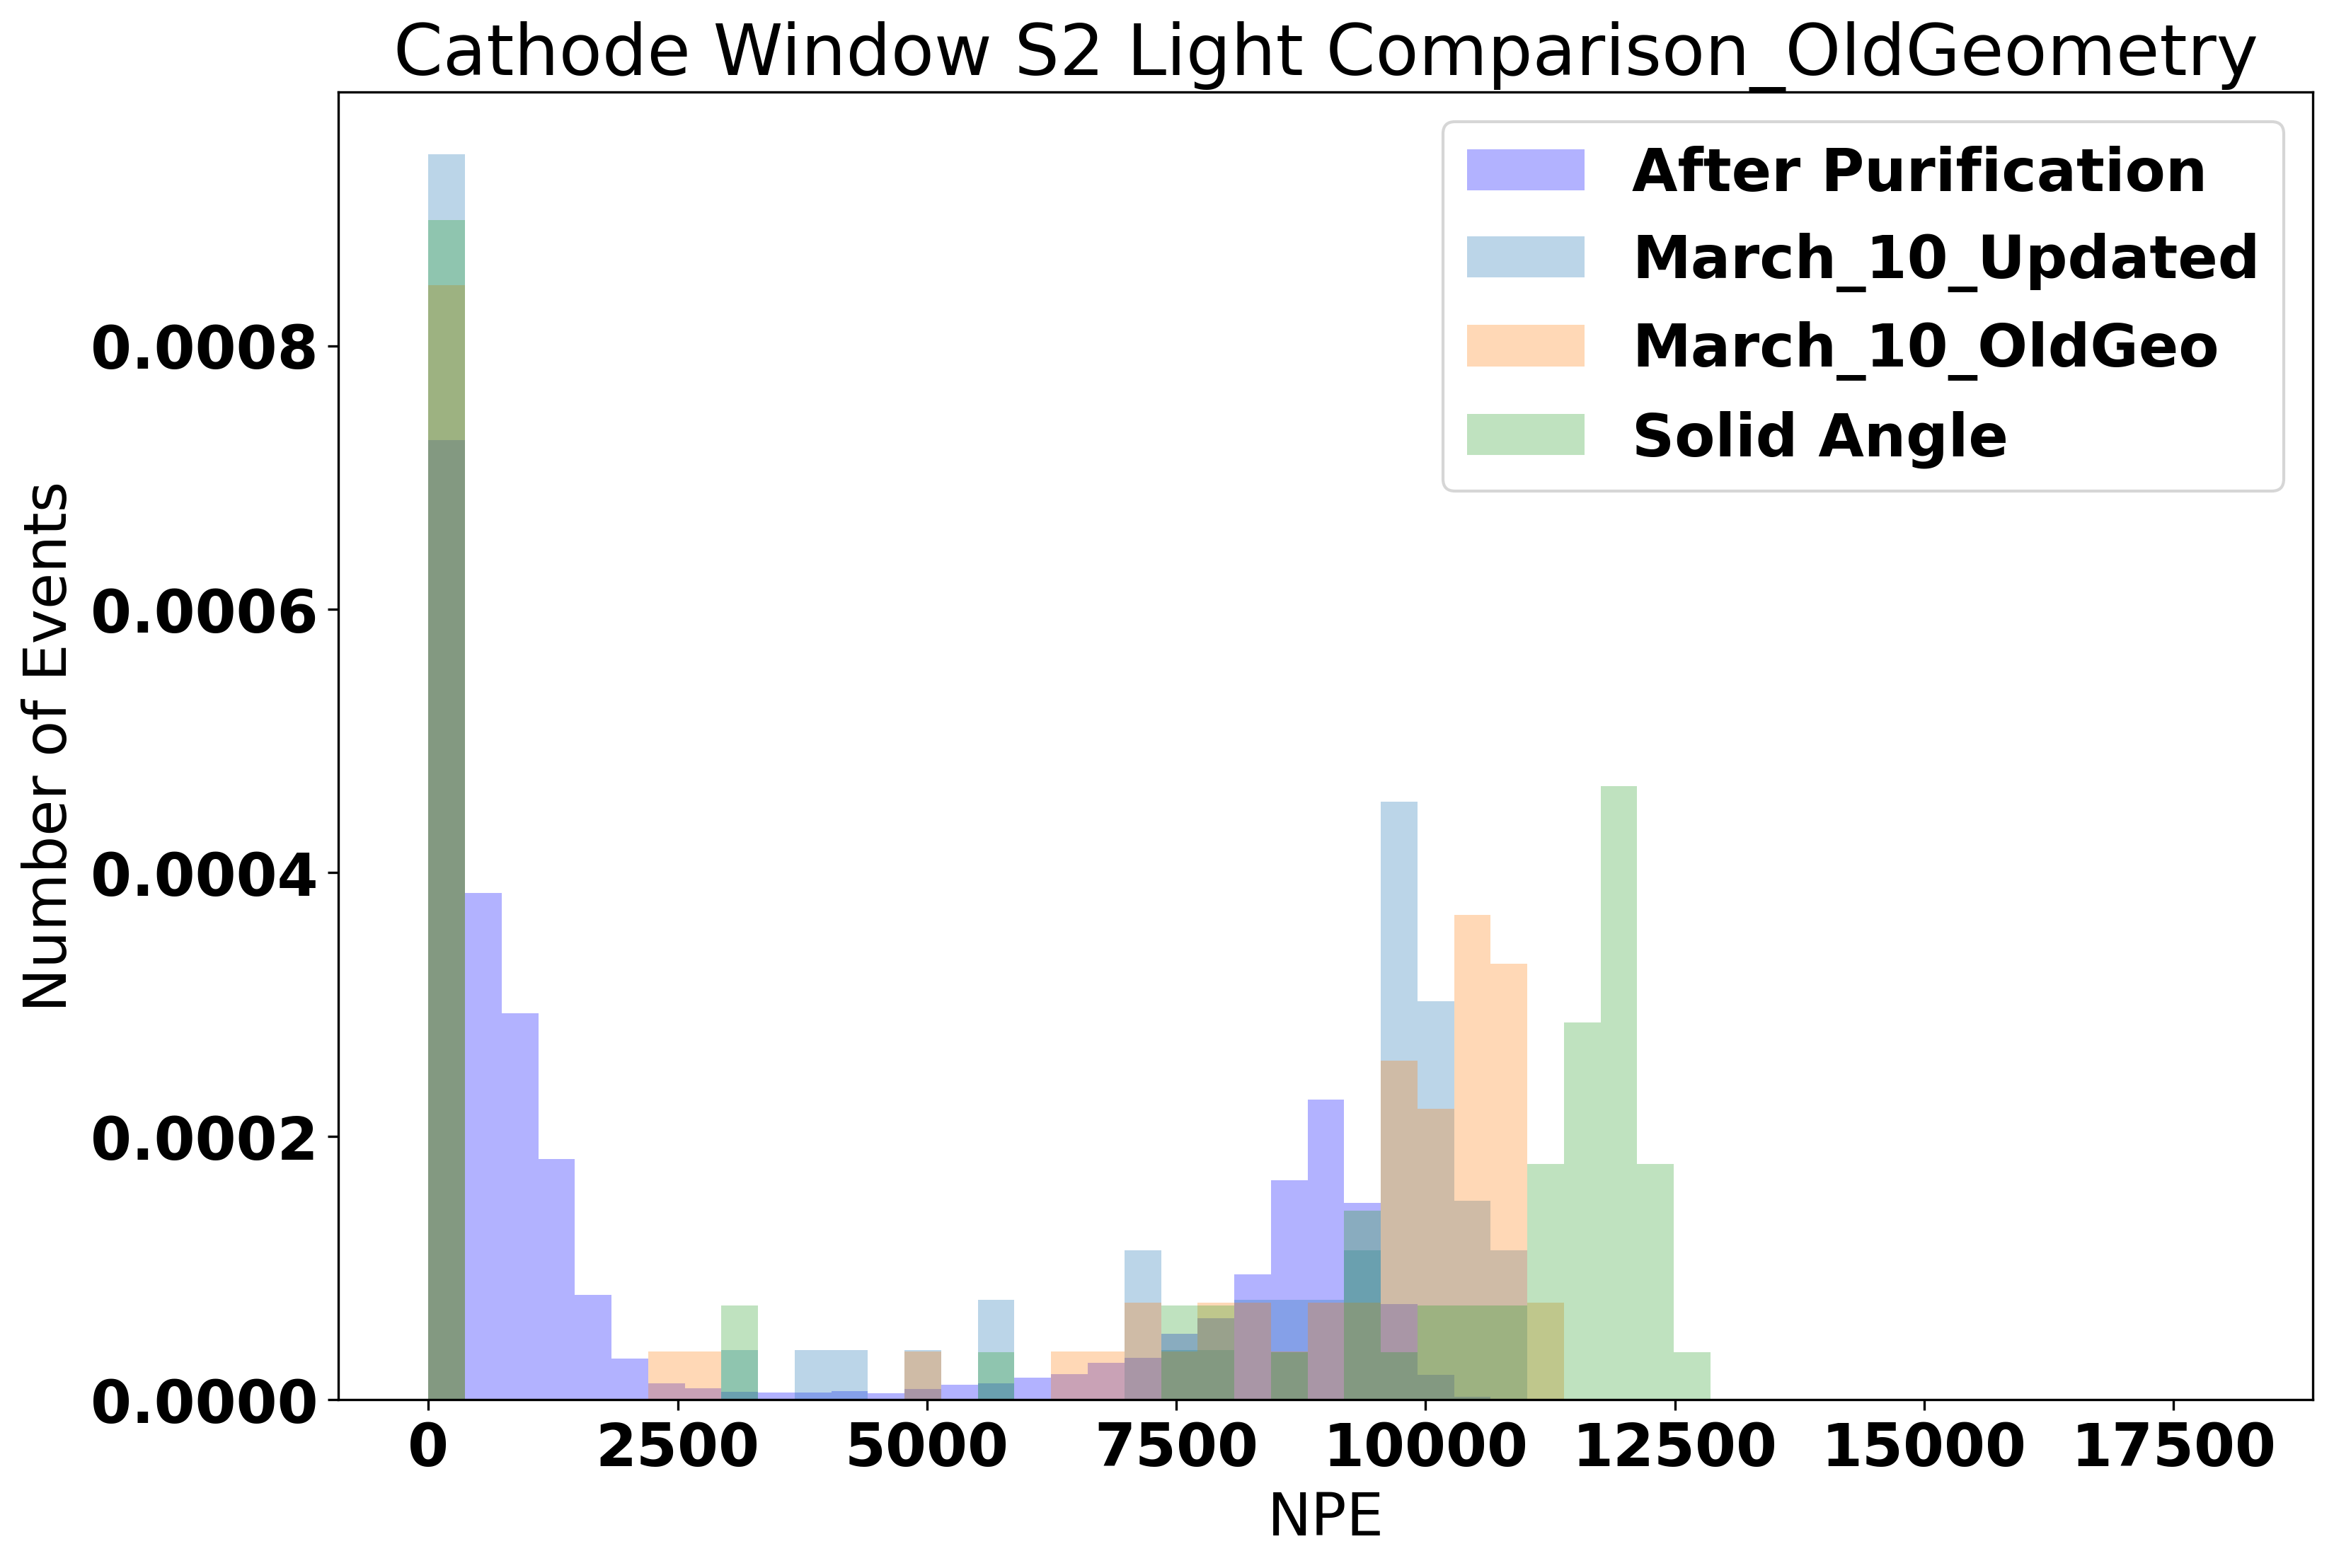

In [10]:



binss=np.linspace(0,18000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode Window S2 Light Comparison_OldGeometry")
plt.ylabel("Number of Events")
plt.xlabel("NPE")

plt.hist(Day2_PMT1_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
plt.hist(March_10_Updated["AnodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="March_10_Updated",alpha=0.3)
plt.hist(March_10_OldGeo["AnodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="March_10_OldGeo",alpha=0.3)
plt.hist(March_10_OldGeo["AnodeAlphaPEs_SolidAngle"],bins=binss ,density=True,stacked=True,label="Solid Angle",alpha=0.3)


plt.legend()
plt.show()

In [11]:
###
Constants={
    "Disc":"Old_geometry_No_S1",
    "Path":"/media/ilker/Ilker/SimResults/Mar_9_2023/OldGeo/counts/Extra_*.txt",
    "AnodeQE":0.11,
    "CathodeQE":0.11,
    "Smearing":(7.17/(2.355*100)), 
    "ELGain":647,
    "AnodeScale":0.91,
    "CathodeScale":0.85,
    "CathodeWindowRadius":(16.58/10)/2,
    "AnodeWindowRadius":(16.22/10)/2,
    "AnodePMTDistance" :14,
    "CathodePMTDistance" :36,
    "Updated":False
}
March_9_OldGeo=ObtainValues(Constants)

Constants={
    "Disc":"Updated_Geometry_NoS1",
    "Path":"/media/ilker/Ilker/SimResults/Mar_9_2023/Updated/counts/Extra_*.txt",
    "AnodeQE":0.10,
    "CathodeQE":0.10,
    "Smearing":(7.17/(2.355*100)), 
    "ELGain":647,
    "AnodeScale":0.91,
    "CathodeScale":0.85,
    "CathodeWindowRadius":(16.58/10)/2,
    "AnodeWindowRadius":(16.22/10)/2,
    "AnodePMTDistance" :14,
    "CathodePMTDistance" :36,
    "Updated":True
}
March_9_Updated=ObtainValues(Constants)

Constants={
    "Disc":"Test_NoS1",
    "Path":"/media/ilker/Ilker/SimResults/Mar_9_2023/test/counts/Extra_*.txt",
    "AnodeQE":0.10,
    "CathodeQE":0.10,
    "Smearing":(7.17/(2.355*100)), 
    "ELGain":647,
    "AnodeScale":0.91,
    "CathodeScale":0.85,
    "CathodeWindowRadius":(16.58/10)/2,
    "AnodeWindowRadius":(16.22/10)/2,
    "AnodePMTDistance" :14,
    "CathodePMTDistance" :36,
    "Updated":False
}
March_9_Test=ObtainValues(Constants)




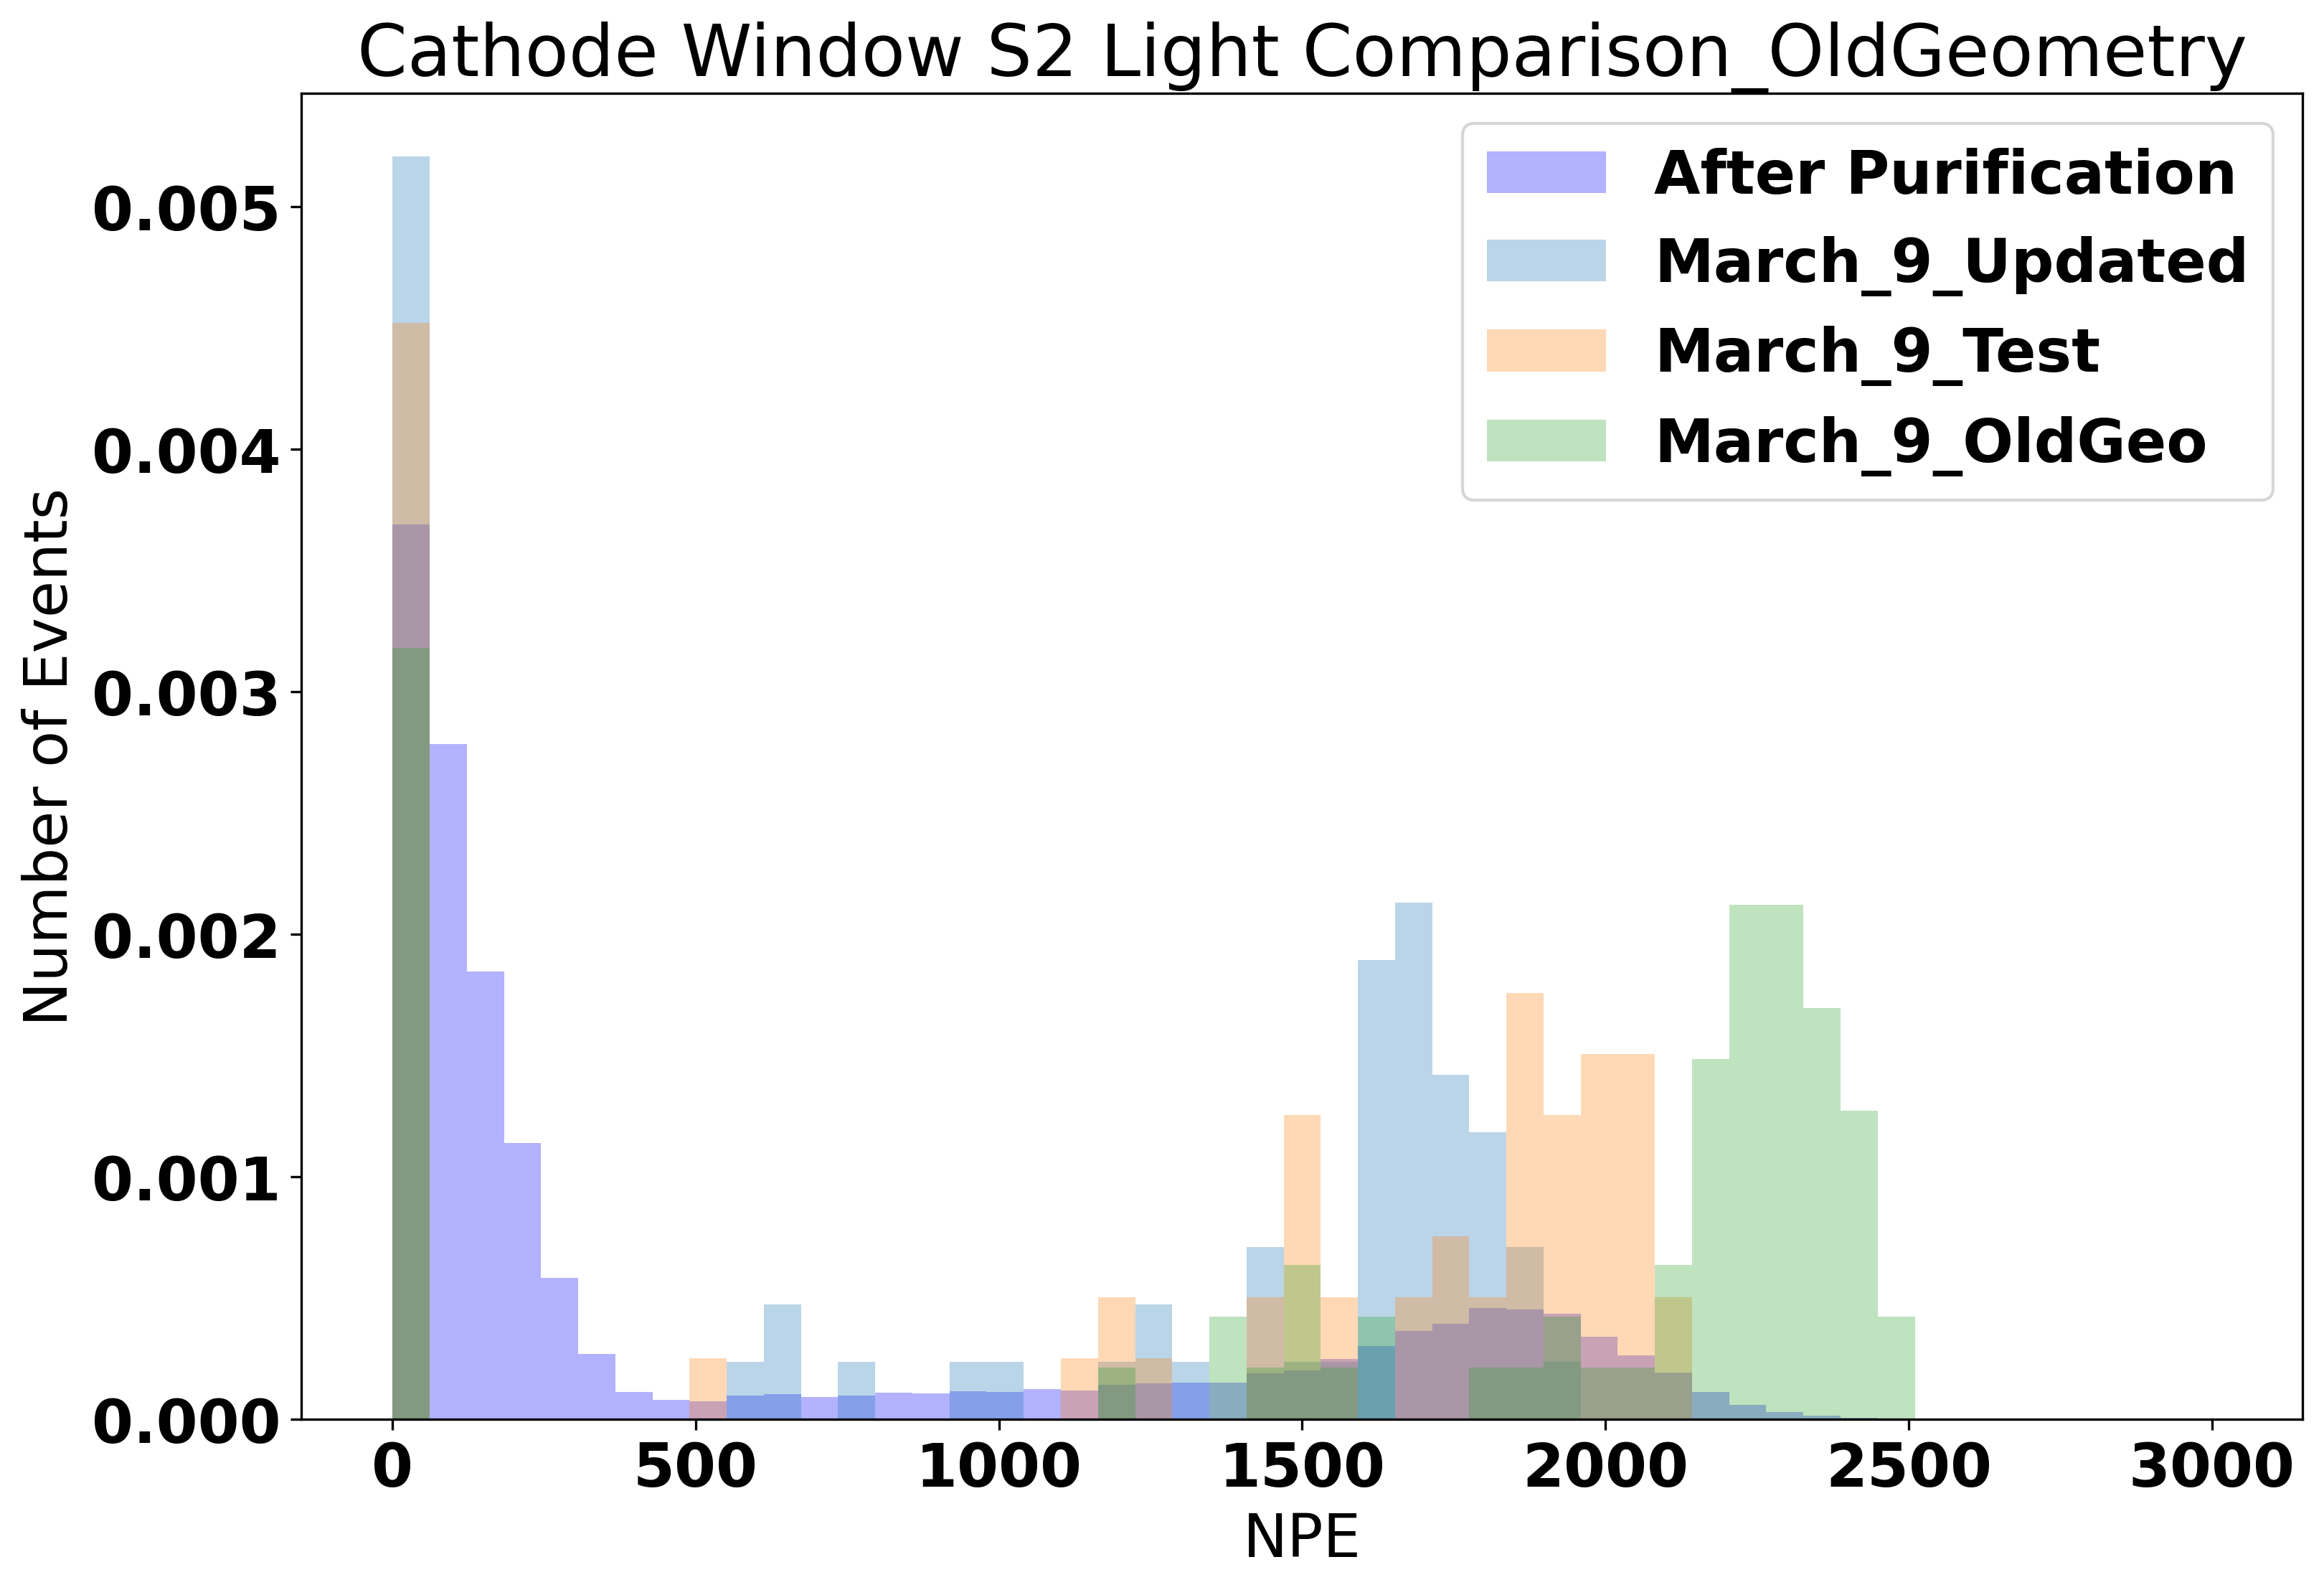

In [12]:
### Data Comp. Day2 PMT3 Comparison

binss=np.linspace(0,3000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode Window S2 Light Comparison_OldGeometry")
plt.ylabel("Number of Events")
plt.xlabel("NPE")

plt.hist(Day2_PMT3_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
plt.hist(March_9_Updated["CathodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="March_9_Updated",alpha=0.3)
plt.hist(March_9_Test["CathodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="March_9_Test",alpha=0.3)
plt.hist(March_9_OldGeo["CathodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="March_9_OldGeo",alpha=0.3)


plt.legend()
plt.show()

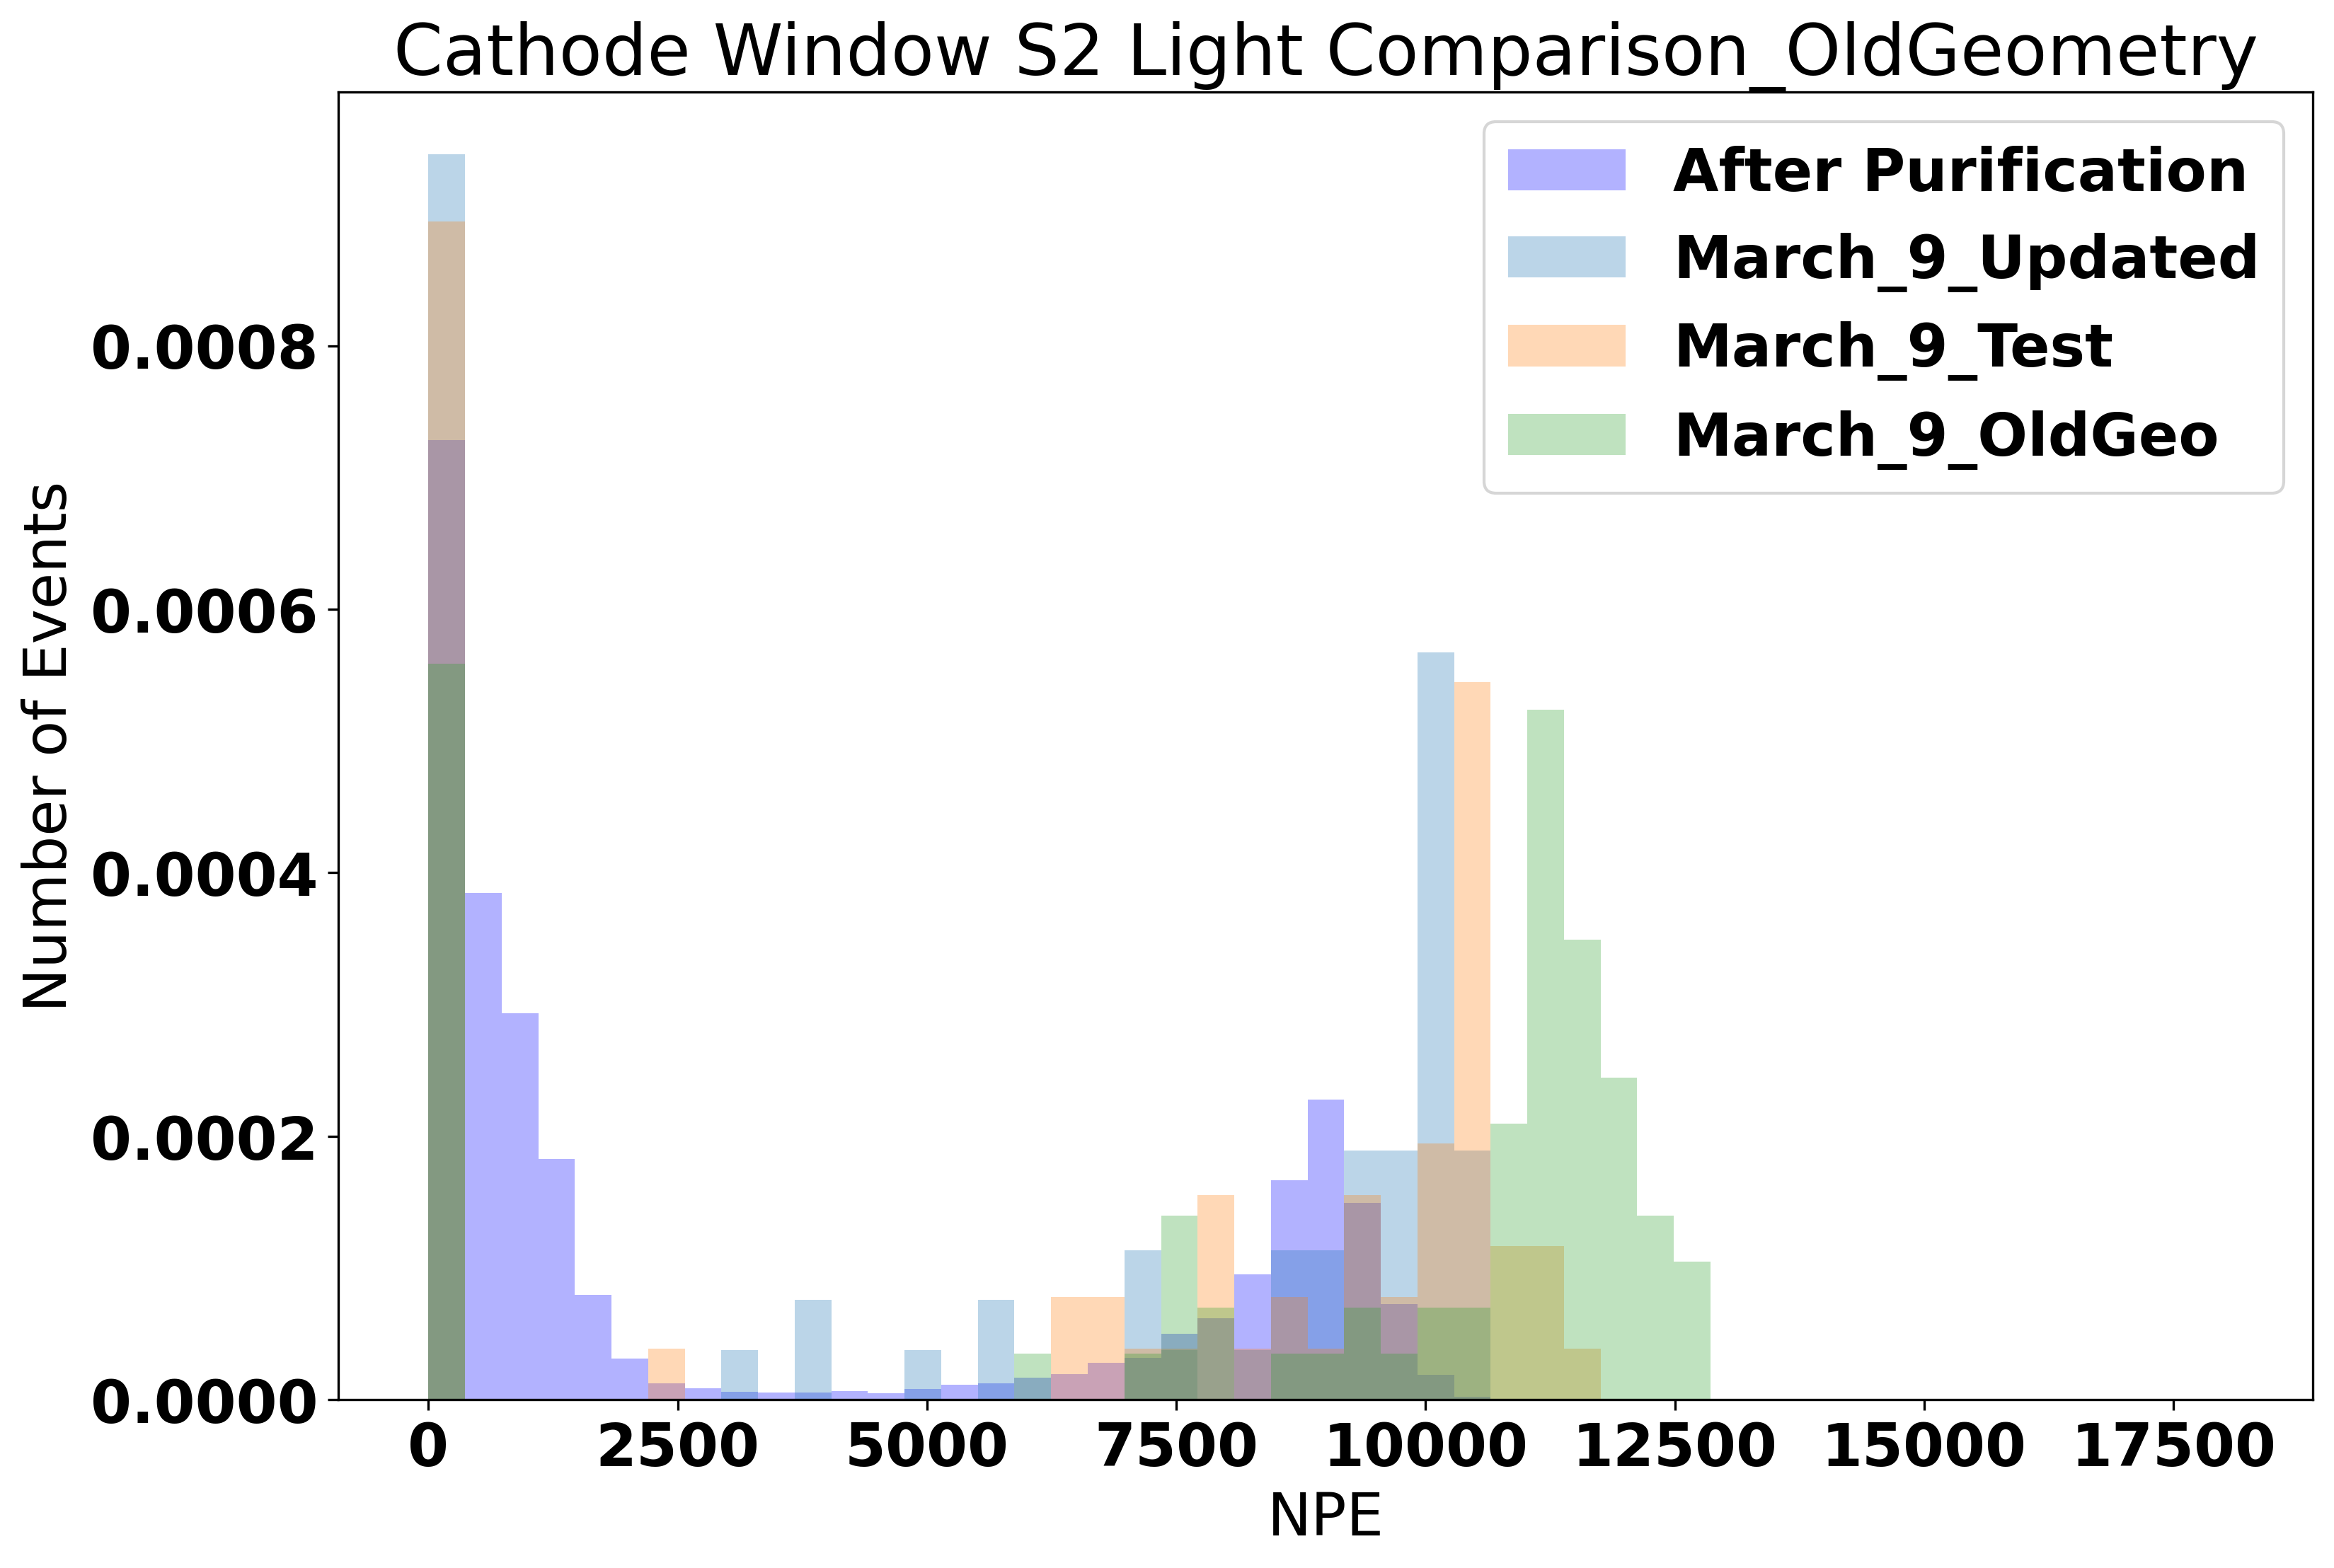

In [13]:
binss=np.linspace(0,18000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode Window S2 Light Comparison_OldGeometry")
plt.ylabel("Number of Events")
plt.xlabel("NPE")

plt.hist(Day2_PMT1_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
plt.hist(March_9_Updated["AnodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="March_9_Updated",alpha=0.3)
plt.hist(March_9_Test["AnodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="March_9_Test",alpha=0.3)
plt.hist(March_9_OldGeo["AnodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="March_9_OldGeo",alpha=0.3)

plt.legend()
plt.show()

In [14]:
#### Comparing Older DATA

Constants={
    "Disc":"Test_Old_geometry_With_S1",
    "Path":"/media/ilker/Ilker/SimResults/Mar_9_2023/test_OldGeo/counts/Extra_*.txt",
    "AnodeQE":0.2,
    "CathodeQE":0.2,
    "Smearing":(7.17/(2.355*100)), 
    "ELGain":647,
    "AnodeScale":0.91,
    "CathodeScale":0.85,
    "CathodeWindowRadius":0.5,
    "AnodeWindowRadius":0.5,
    "AnodePMTDistance" :14,
    "CathodePMTDistance" :36,
    "Updated":False
}
March_9_TestOldGeo=ObtainValues(Constants)

Constants={
    "Disc":"Updated_Geometry_NoS1",
    "Path":"/media/ilker/Ilker/SimResults/Mar4_2022/NewGeometry/Original/counts/Extra_*.txt",
    "AnodeQE":0.2,
    "CathodeQE":0.2,
    "Smearing":(7.17/(2.355*100)), 
    "ELGain":647,
    "AnodeScale":0.91,
    "CathodeScale":0.85,
    "CathodeWindowRadius":0.5,
    "AnodeWindowRadius":0.5,
    "AnodePMTDistance" :14,
    "CathodePMTDistance" :36,
    "Updated":True
}
March_4_Updated=ObtainValues(Constants)


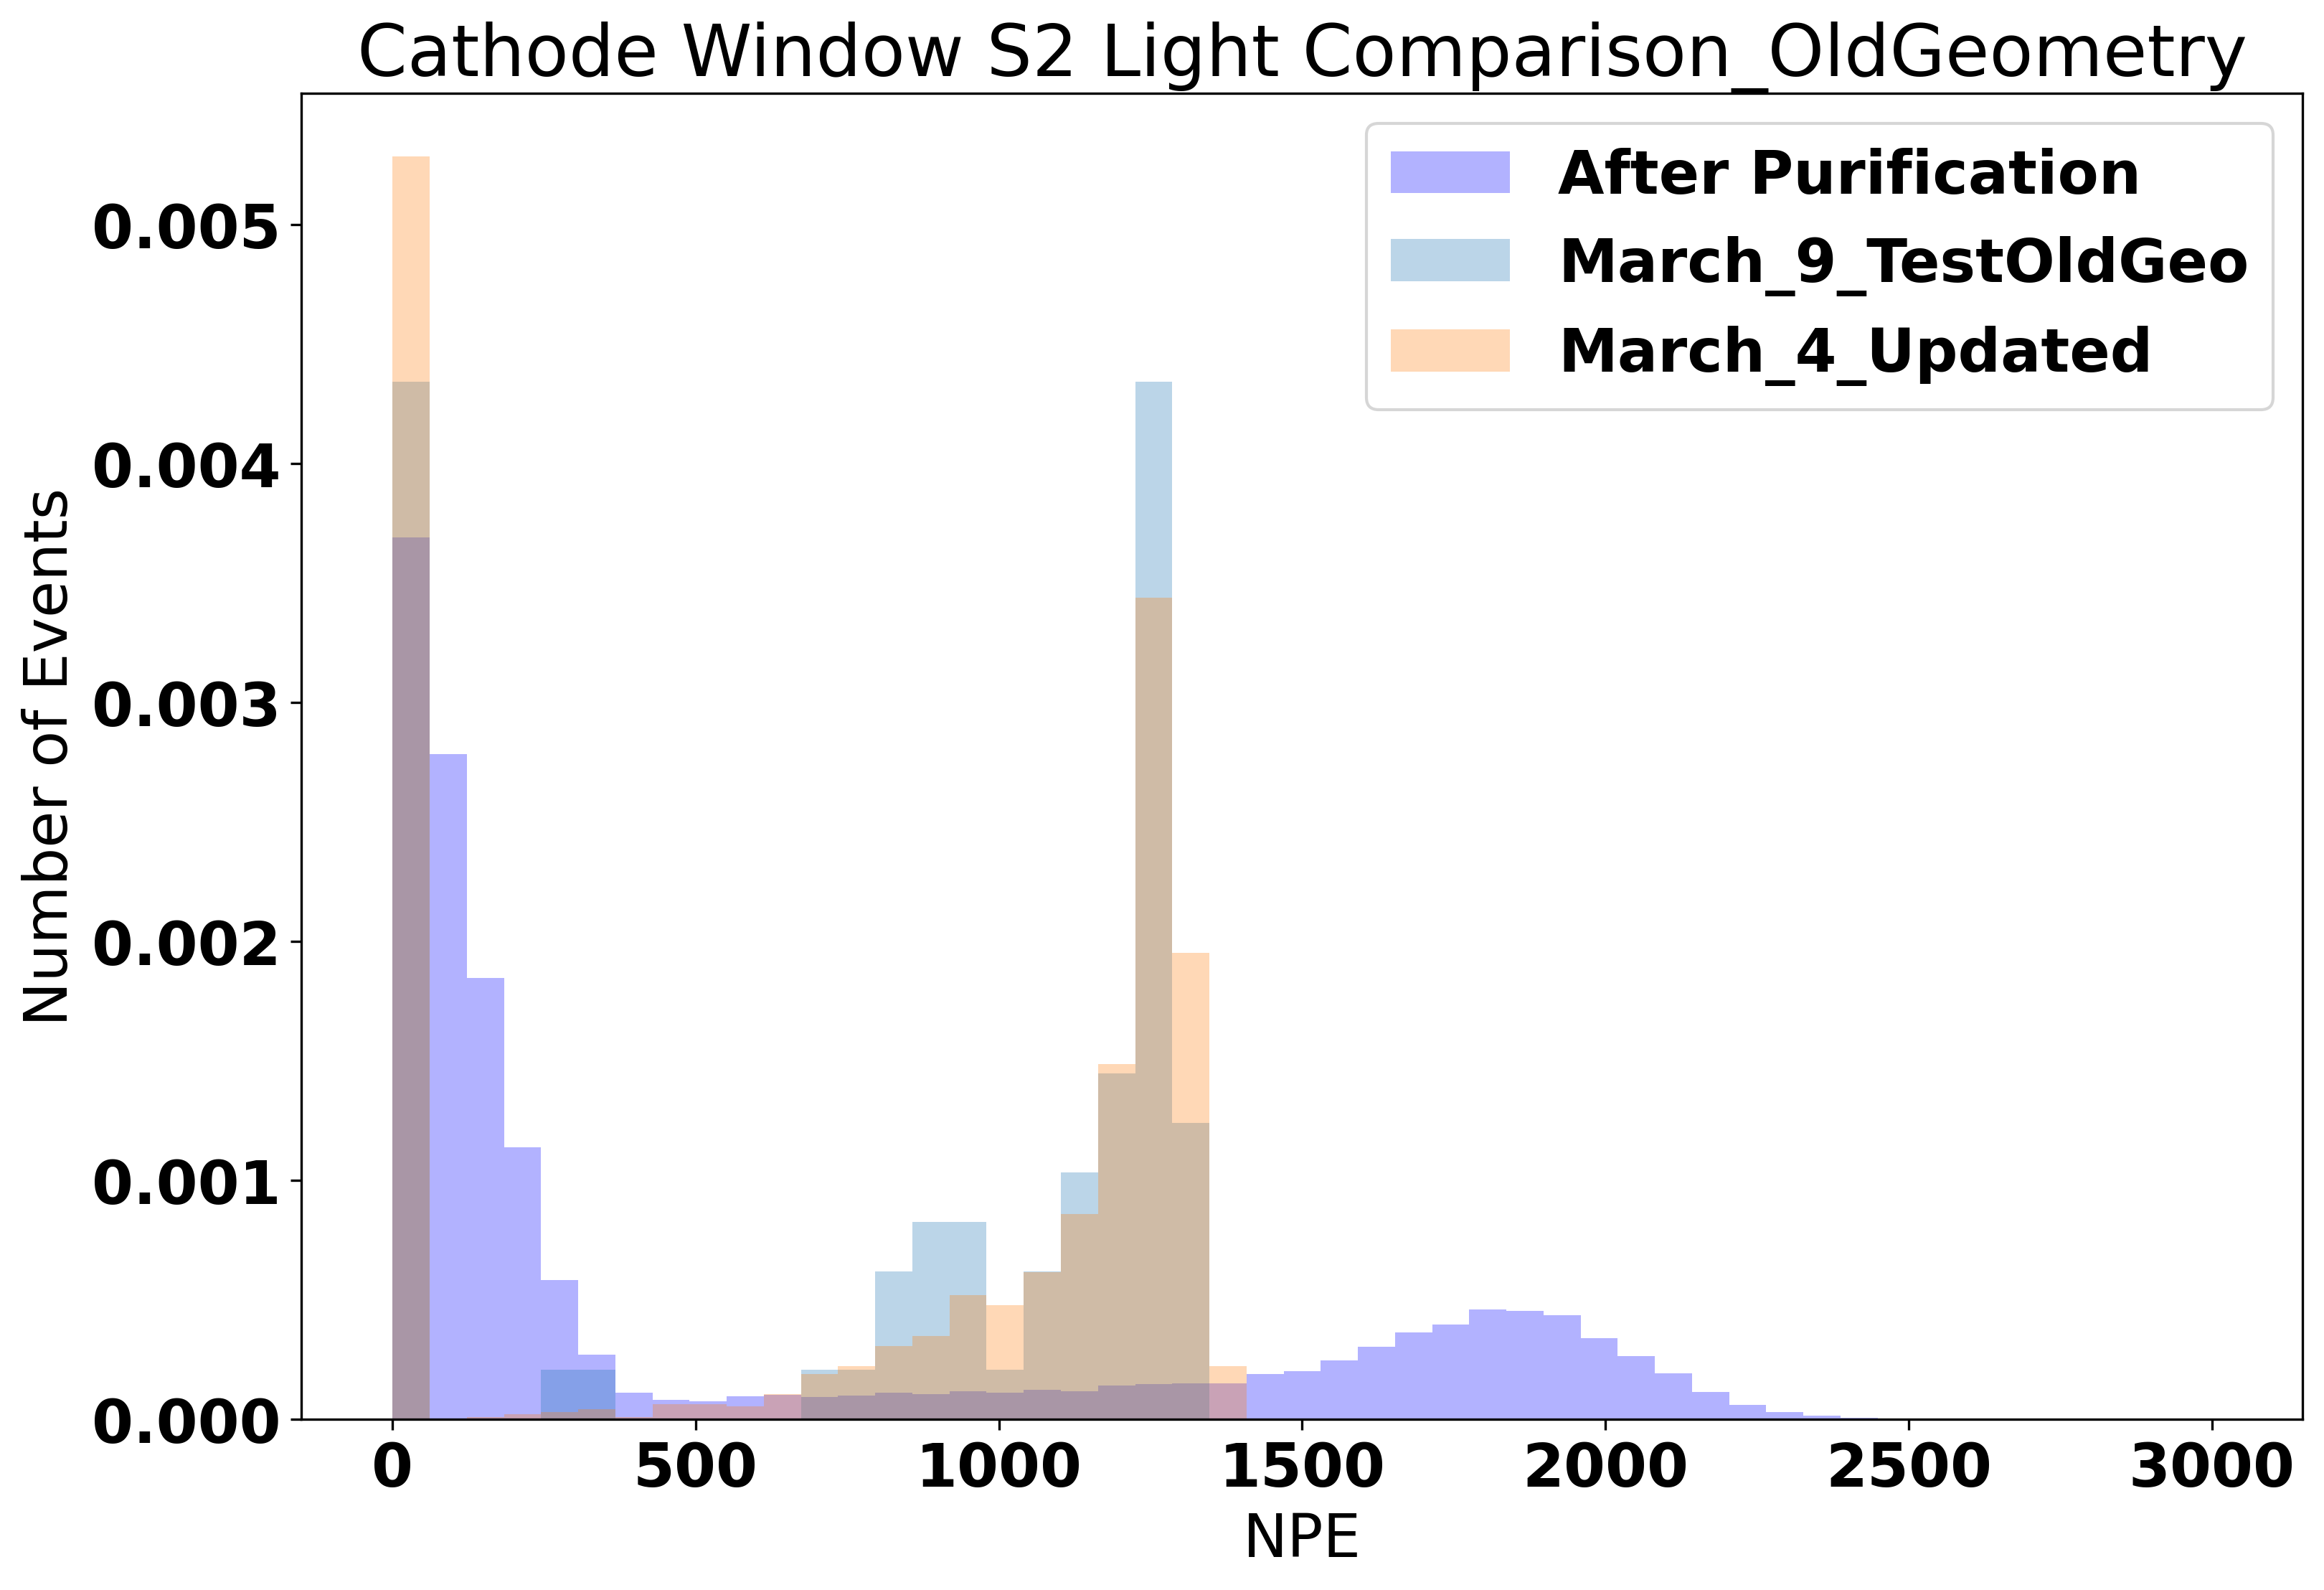

In [15]:
### Data Comp. Day2 PMT3 Comparison

binss=np.linspace(0,3000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode Window S2 Light Comparison_OldGeometry")
plt.ylabel("Number of Events")
plt.xlabel("NPE")

plt.hist(Day2_PMT3_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
plt.hist(March_9_TestOldGeo["CathodeAlphaPEs_SolidAngle"],bins=binss ,density=True,stacked=True,label="March_9_TestOldGeo",alpha=0.3)
plt.hist(March_4_Updated["CathodeAlphaPEs_SolidAngle"],bins=binss ,density=True,stacked=True,label="March_4_Updated",alpha=0.3)


plt.legend()
plt.show()

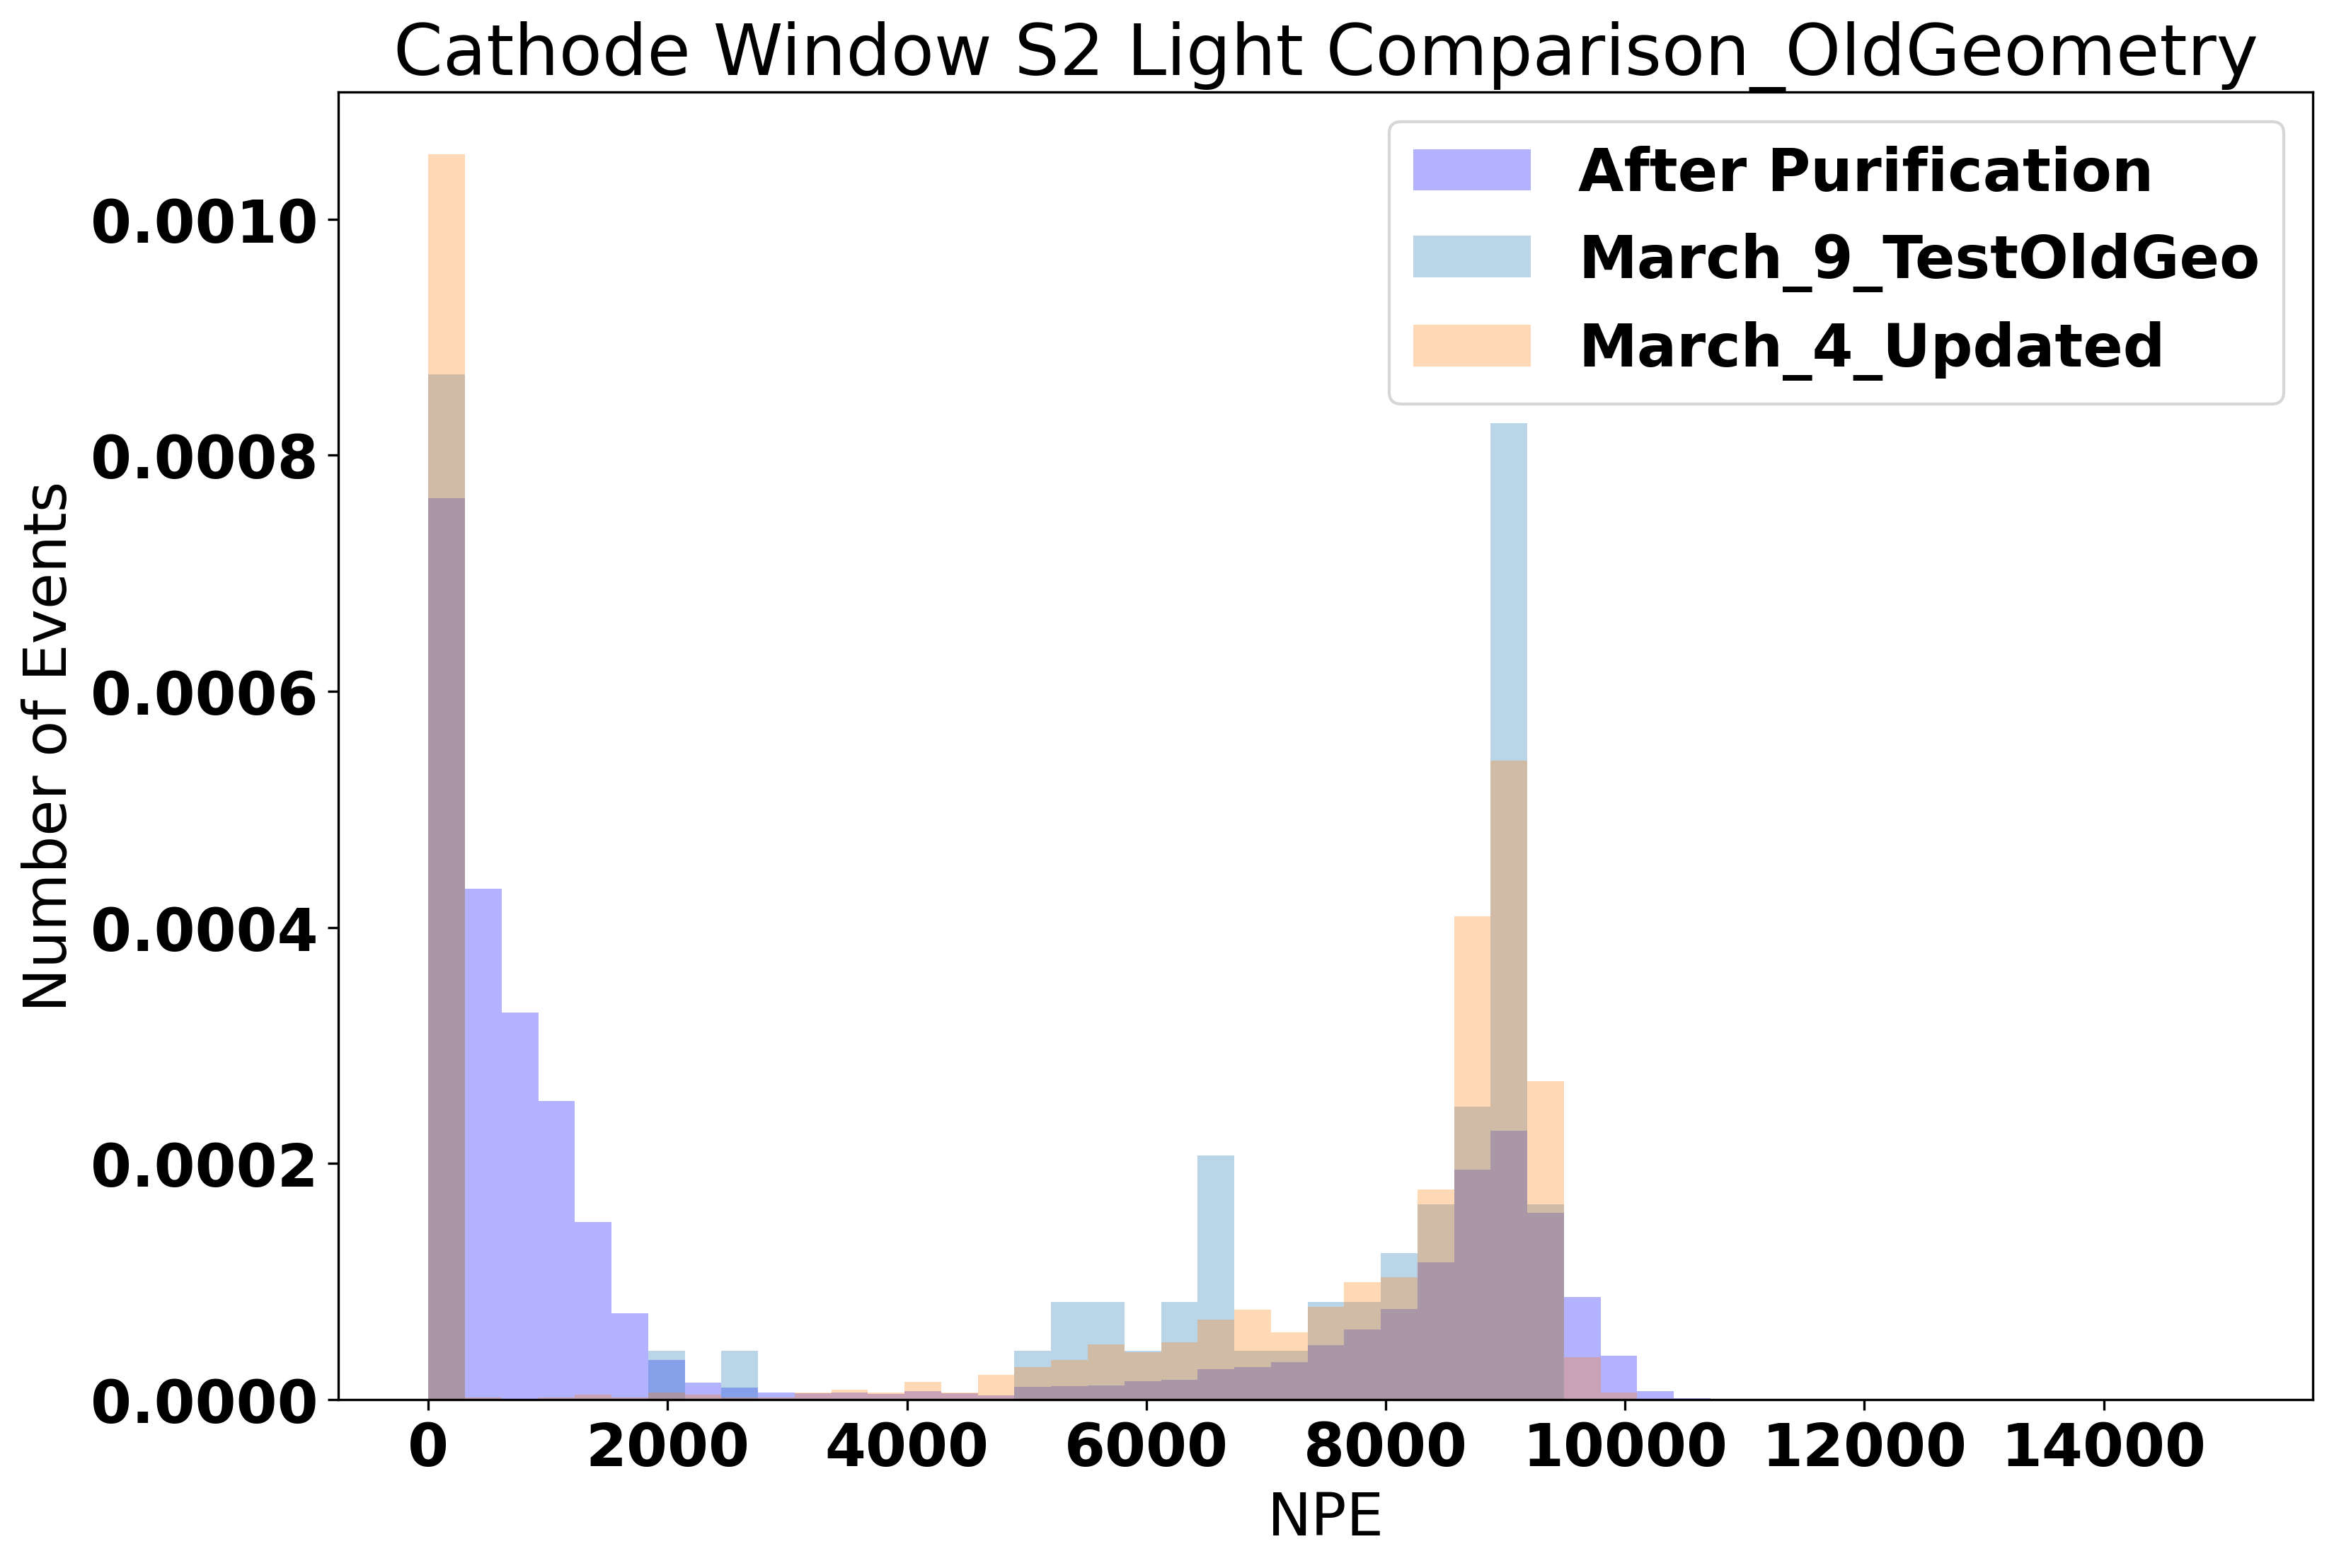

In [16]:
### Data Comp. Day2 PMT3 Comparison

binss=np.linspace(0,15000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode Window S2 Light Comparison_OldGeometry")
plt.ylabel("Number of Events")
plt.xlabel("NPE")

plt.hist(Day2_PMT1_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
plt.hist(March_9_TestOldGeo["AnodeAlphaPEs_SolidAngle"],bins=binss ,density=True,stacked=True,label="March_9_TestOldGeo",alpha=0.3)
plt.hist(March_4_Updated["AnodeAlphaPEs_SolidAngle"],bins=binss ,density=True,stacked=True,label="March_4_Updated",alpha=0.3)


plt.legend()
plt.show()